In [1]:
# Import necessary libraries for the analysis

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

In [2]:
# Collects Nvidia & Ethereum stock price data from Yahoo Finance

today = date.today()
start_date ="2021-01-01"
end_date = today.strftime("%m/%d/%Y")

stock_data = yf.download("NVDA ETH-USD", start=start_date)
stock_data.tail(5)

[*********************100%***********************]  2 of 2 completed


Adj Close                    Close                     High  \
                ETH-USD        NVDA      ETH-USD        NVDA      ETH-USD   
Date                                                                        
2022-07-06  1186.973999  151.300003  1186.973999  151.300003  1193.636719   
2022-07-07  1237.593384  158.580002  1237.593384  158.580002  1246.894897   
2022-07-08  1222.506226  158.380005  1222.506226  158.380005  1262.885742   
2022-07-09  1216.978271         NaN  1216.978271         NaN  1228.767944   
2022-07-10  1176.385132         NaN  1176.385132         NaN  1216.797607   

                                Low                     Open              \
                  NVDA      ETH-USD        NVDA      ETH-USD        NVDA   
Date                                                                       
2022-07-06  153.190002  1116.247559  147.889999  1134.822266  150.100006   
2022-07-07  159.449997  1165.623169  153.889999  1186.960938  154.559998   
2022-07-08  160.369995  1200.632202  153.889999  1237.580322  154.300003   
2022-07-09         NaN  1209.377563         NaN  1222.306885         NaN   
2022-07-10         NaN  1157.456055         NaN  1216.683228         NaN   

                 Volume              
                ETH-USD        NVDA  
Date                                 
2022-07-06  15373536703  52906600.0  
2022-07-07  14230795894  49290300.0  
2022-07-08  16315929082  46763500.0  
2022-07-09   8821353104         NaN  
2022-07-10  10235341824         NaN

In [3]:
stock_data = stock_data[[("Adj Close", "ETH-USD"), ("Adj Close", "NVDA")]]

# Removes column multi-index level since we want adjusted close price

stock_data = stock_data[[("Adj Close", "ETH-USD"), ("Adj Close", "NVDA")]]
stock_data.columns = stock_data.columns.droplevel(0)
stock_data = stock_data.rename_axis(None, axis=1)
stock_data.tail(5)

,ETH-USD,NVDA
Date,,
2022-07-06,1186.973999,151.300003
2022-07-07,1237.593384,158.580002
2022-07-08,1222.506226,158.380005
2022-07-09,1216.978271,NaN
2022-07-10,1176.385132,NaN


In [4]:
# Finds the Pearson correlation coefficient

correlation = stock_data.corr(method="pearson")
correlation

,ETH-USD,NVDA
ETH-USD,1.000000,0.785595
NVDA,0.785595,1.000000


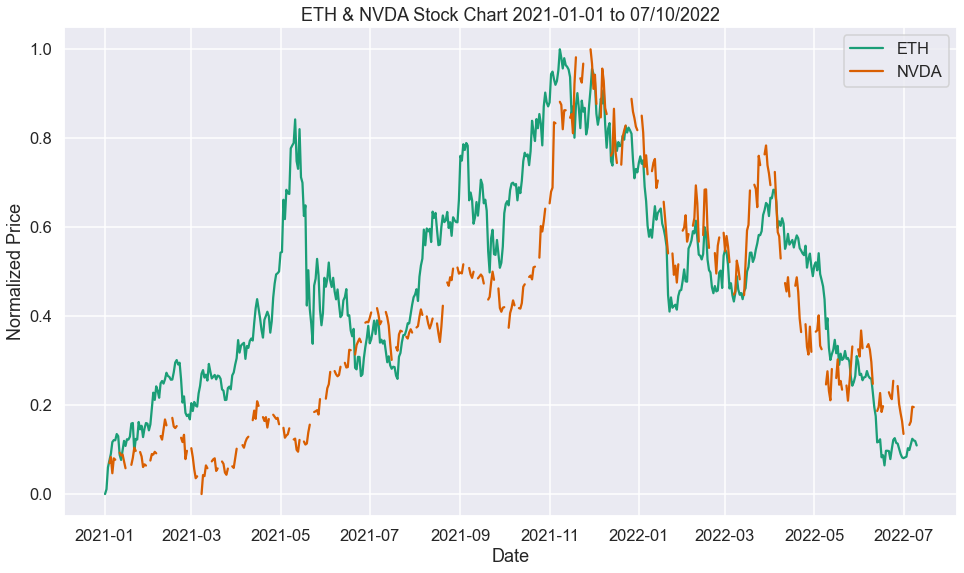

In [5]:
# Reshapes the data for MinMaxScaler transform

ETH_data, NVDA_data = stock_data["ETH-USD"].values, stock_data["NVDA"].values
ETH_data, NVDA_data = ETH_data.reshape(-1, 1), NVDA_data.reshape(-1, 1)

# Plots normalized stock price of each symbol

scaler = MinMaxScaler()

sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(16,9))


ax.set_xlabel("Date")
ax.set_ylabel("Normalized Price")
ax.set_title(f"ETH & NVDA Stock Chart {start_date} to {end_date}")

ax.plot(stock_data.index, scaler.fit_transform(ETH_data), label="ETH")
ax.plot(stock_data.index, scaler.fit_transform(NVDA_data), label="NVDA")
ax.legend()

In [6]:
# Creates percent change columns based on last adjusted close amount

for column in stock_data.columns:
    stock_data[f"{column} Prev Close"] = stock_data[f"{column}"].shift(1)
    stock_data[f"{column} % Change"] = (stock_data[f"{column}"] / stock_data[f"{column} Prev Close"]) - 1

stock_data.tail(5)

,ETH-USD,NVDA,ETH-USD Prev Close,ETH-USD % Change,NVDA Prev Close,NVDA % Change
Date,,,,,,
2022-07-06,1186.973999,151.300003,1134.541016,0.046215,149.639999,0.011093
2022-07-07,1237.593384,158.580002,1186.973999,0.042646,151.300003,0.048116
2022-07-08,1222.506226,158.380005,1237.593384,-0.012191,158.580002,-0.001261
2022-07-09,1216.978271,NaN,1222.506226,-0.004522,158.380005,NaN
2022-07-10,1176.385132,NaN,1216.978271,-0.033356,NaN,NaN


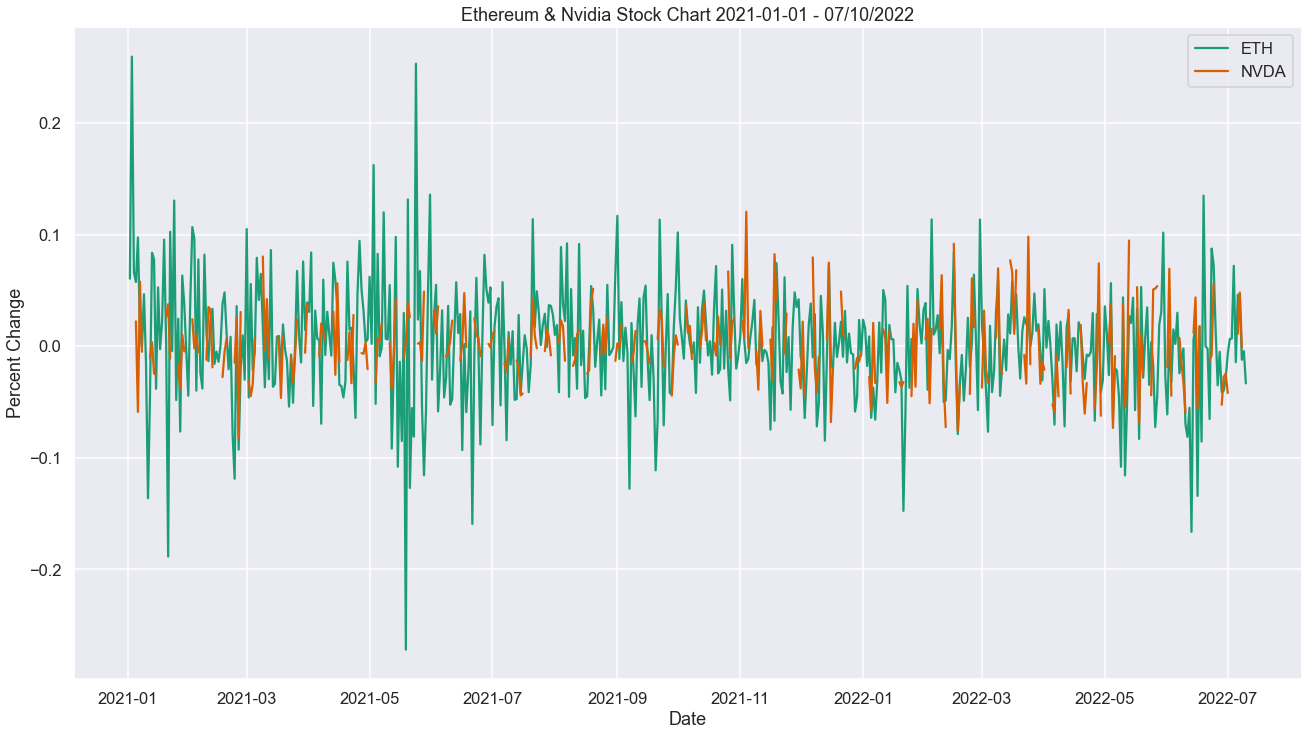

In [7]:
# Plots percent change of ETH and NVDA price

fig2, ax2 = plt.subplots(figsize=(22,12))

ax2.set_xlabel("Date")
ax2.set_ylabel("Percent Change")
ax2.set_title(f"Ethereum & Nvidia Stock Chart {start_date} - {end_date}")

ax2.plot(stock_data.index, stock_data['ETH-USD % Change'], label="ETH")
ax2.plot(stock_data.index, stock_data["NVDA % Change"], label="NVDA")
ax2.legend()

In [8]:
# Creates an indicator column to see if NVDA & ETH stock price move in a same direction. 1 to signal yes and 0 to signal no

indicator_data = stock_data.copy()
indicator_data.dropna(inplace=True)
indicator_data["Indicator"] = np.where(np.sign(indicator_data["ETH-USD % Change"]) == np.sign(indicator_data["NVDA % Change"]), 1, 0)
indicator_data.tail(5)

,ETH-USD,NVDA,ETH-USD Prev Close,ETH-USD % Change,NVDA Prev Close,NVDA % Change,Indicator
Date,,,,,,,
2022-06-30,1067.298828,151.589996,1098.943848,-0.028796,155.419998,-0.024643,1
2022-07-01,1059.767334,145.229996,1067.298828,-0.007057,151.589996,-0.041955,1
2022-07-06,1186.973999,151.300003,1134.541016,0.046215,149.639999,0.011093,1
2022-07-07,1237.593384,158.580002,1186.973999,0.042646,151.300003,0.048116,1
2022-07-08,1222.506226,158.380005,1237.593384,-0.012191,158.580002,-0.001261,1


In [9]:
# Calculates a ratio to determine if the stock price tend to increase/decrease together

ratio = indicator_data["Indicator"].sum() / len(indicator_data.index)
print(f"Correct Prediction (%): {round(ratio, 4)*100}")

Correct Prediction (%): 67.11


In [10]:
# Now predicting NVDA stock price using random forest (without ETH)

rf_data = yf.download("NVDA")
rf_data = rf_data[["Adj Close"]]

[*********************100%***********************]  1 of 1 completed


In [11]:
rf_data = rf_data.copy()
rf_data["Prev Close"] = rf_data.shift(1)
rf_data = rf_data.iloc[1:]

In [12]:
# Creates buy/sell signal based on previous day close price. 1 to buy and 0 to sell

rf_data.dropna(inplace=True)
rf_data["Signal"] = np.where(rf_data["Adj Close"] > rf_data["Prev Close"], 1, 0)
rf_data.tail(5)

,Adj Close,Prev Close,Signal
Date,,,
2022-07-01,145.229996,151.589996,0
2022-07-05,149.639999,145.229996,1
2022-07-06,151.300003,149.639999,1
2022-07-07,158.580002,151.300003,1
2022-07-08,158.380005,158.580002,0


In [13]:
# Train-Test split for NVIDIA buy/sell signal prediction

train_set, test_set = rf_data[:-100], rf_data[-100:]
X_train, X_test = train_set["Adj Close"].values.reshape(-1,1), test_set["Adj Close"].values.reshape(-1,1)
y_train, y_test = train_set["Signal"], test_set["Signal"]

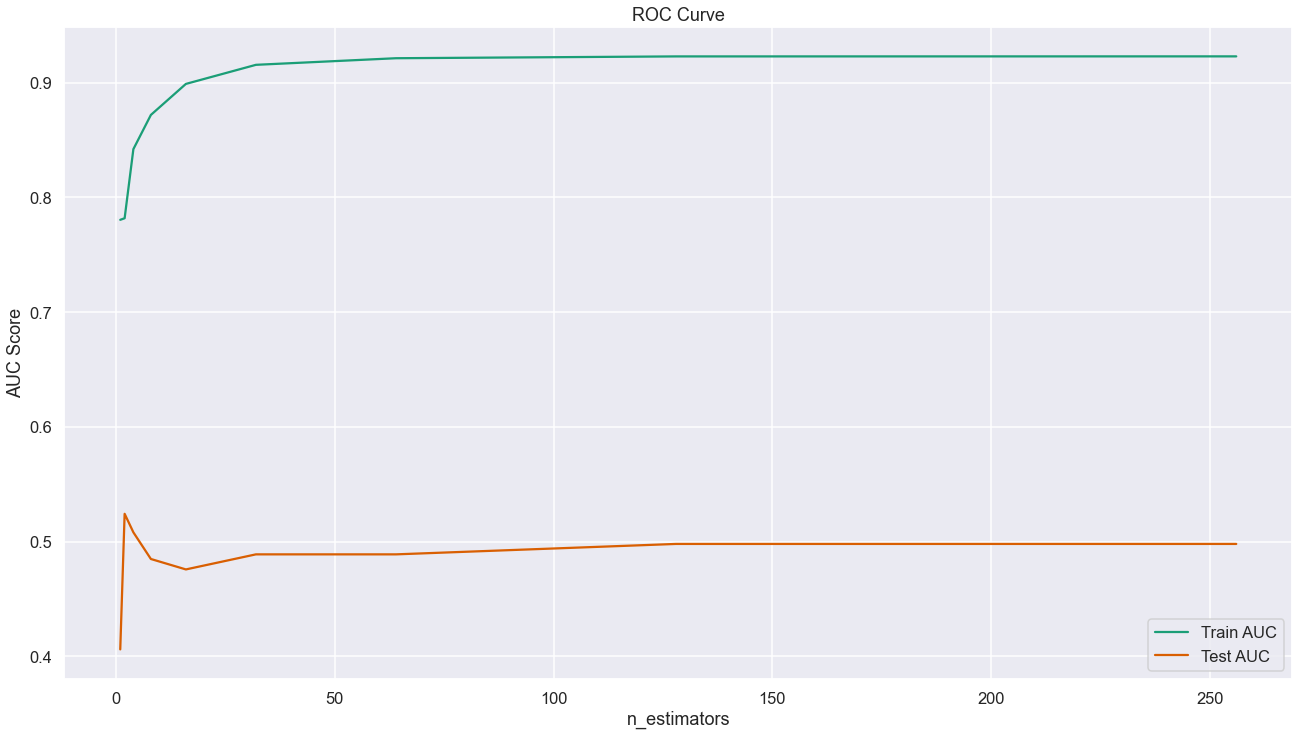

In [14]:
# Uses random forest to generate our prediction on buy/sell signal
# We will tune the parameters to improve accuracy

estimators = [1, 2, 4, 8, 16, 32, 64, 128, 256]

train_estimators = {}
test_estimators = {}

for estimator in estimators:
    model = RandomForestClassifier(n_estimators=estimator, 
                                   random_state=1, 
                                   n_jobs=-1)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_estimators[estimator] = roc_auc
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_estimators[estimator]= roc_auc

# Graphs the AUC scores 
fig3, ax3 = plt.subplots(figsize=(22,12))

ax3.set_xlabel("n_estimators")
ax3.set_ylabel("AUC Score")
ax3.set_title("ROC Curve")

ax3.plot(estimators, list(train_estimators.values()), label="Train AUC")
ax3.plot(estimators, list(test_estimators.values()), label="Test AUC")
ax3.legend()

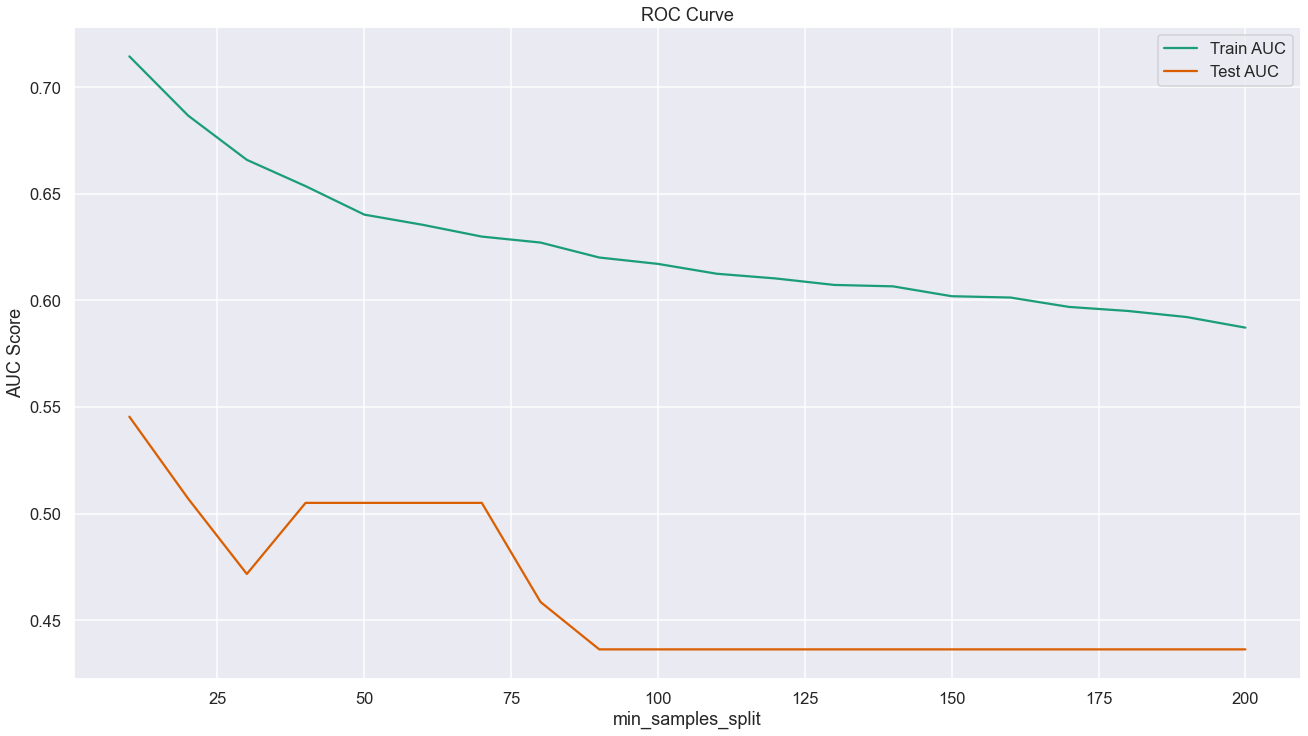

In [15]:
# Uses random forest to generate our prediction on buy/sell signal
# We will tune the parameters to improve accuracy

min_samples_split = [x for x in range(10, 201, 10)]

train_split = {}
test_split = {}

for split in min_samples_split:
    model = RandomForestClassifier(max(test_estimators, key=test_estimators.get), 
                                   min_samples_split=split, 
                                   random_state=1, 
                                   n_jobs=-1)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_split[split] = roc_auc
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_split[split]= roc_auc

# Graphs the AUC scores 
fig4, ax4 = plt.subplots(figsize=(22,12))

ax4.set_xlabel("min_samples_split")
ax4.set_ylabel("AUC Score")
ax4.set_title("ROC Curve")

ax4.plot(min_samples_split, list(train_split.values()), label="Train AUC")
ax4.plot(min_samples_split, list(test_split.values()), label="Test AUC")
ax4.legend()

Correct Prediction (%): 54.0


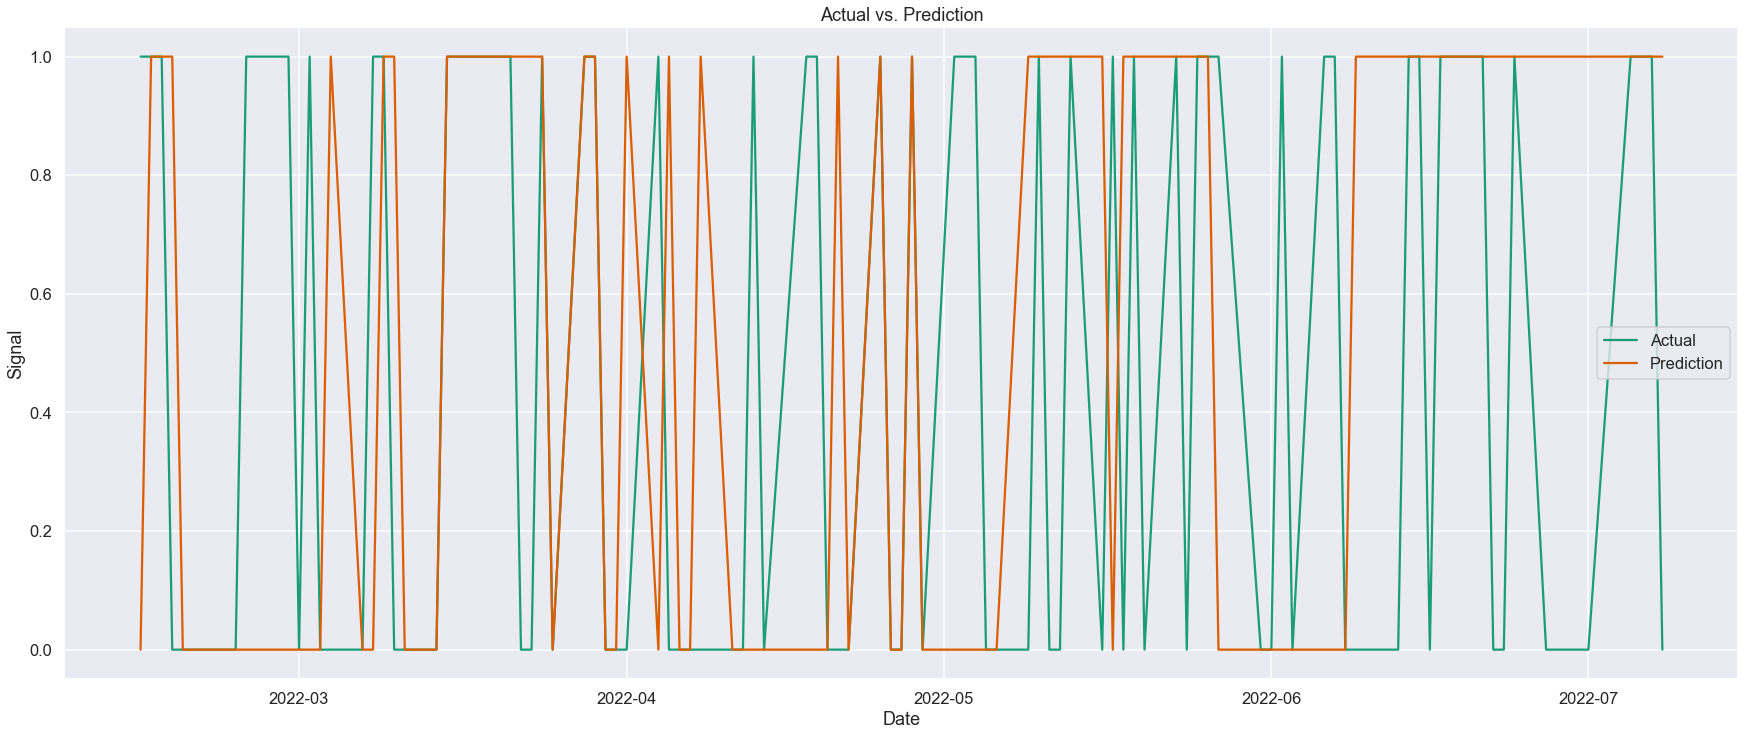

In [16]:
# Predicting our signal with the parameter
model = RandomForestClassifier(n_estimators=max(test_estimators, key=test_estimators.get), 
                               min_samples_split=max(test_split, key=test_split.get), 
                               random_state=1)
model.fit(X_train, y_train)

# Evaluate error of predictions

y_pred = model.predict(X_test)
y_true = np.array(y_test)

# Plotting against our predicted value and actual value

fig4, ax4 = plt.subplots(figsize=(30,12))

ax4.set_xlabel("Date")
ax4.set_ylabel("Signal")
ax4.set_title("Actual vs. Prediction")

ax4.plot(test_set["Signal"], label="Actual")
ax4.plot(pd.Series(y_pred, test_set.index), label="Prediction")
ax4.legend()

print(f"Correct Prediction (%): {round(accuracy_score(y_true, y_pred, normalize=True)*100,4)}")

In [17]:
def backtest(data, model, features, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        X_train, X_test = train[features], test[features]
        y_train, y_test = train["Signal"], test["Signal"]
    
        # Fit the random forest model
        model.fit(X_train, y_train)

        # Make predictions
        preds = model.predict_proba(X_test)[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > 0.6] = 1
        preds[preds <= 0.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Signal": y_test,"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [18]:
# Note that signal is the only feature for now.

features = ["Adj Close"]

predictions = backtest(rf_data, model, features)
y_pred = predictions["Predictions"]
y_true = predictions["Signal"]

In [19]:
print(f"Correct Prediction (%): {round(accuracy_score(y_true, y_pred, normalize=True)*100,4)}")

Correct Prediction (%): 51.2648


In [20]:
# More features that indicate trends

weekly_mean = rf_data.rolling(7).mean()["Adj Close"]
quarterly_mean = rf_data.rolling(90).mean()["Adj Close"]
annual_mean = rf_data.rolling(365).mean()["Adj Close"]

rf_data["weekly_mean"] = weekly_mean / rf_data["Adj Close"]
rf_data["quarterly_mean"] = quarterly_mean / rf_data["Adj Close"]
rf_data["annual_mean"] = annual_mean / rf_data["Adj Close"]
rf_data["annual_weekly_mean"] = rf_data["annual_mean"] / rf_data["weekly_mean"]
rf_data["annual_quarterly_mean"] = rf_data["annual_mean"] / rf_data["quarterly_mean"]

In [21]:
# Let's include more features that we created

full_features = features + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean"]

full_predictions = backtest(rf_data.iloc[365:], model, full_features)
y_pred = full_predictions["Predictions"]
y_true = full_predictions["Signal"]

In [22]:
print(f"Correct Prediction (%): {round(accuracy_score(y_true, y_pred, normalize=True)*100,4)}")

Correct Prediction (%): 61.1197
